In [37]:
import numpy as np
import matplotlib.pyplot as plt
import eleanor
import batman
from scipy.optimize import minimize
import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


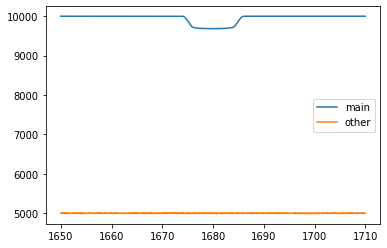

In [2]:
params = batman.TransitParams()
params.t0 = 0.                              #time of inferior conjunction
params.per = 60.                             #orbital period 
params.rp = 0.17                             #planet radius (in units of stellar radii)
params.a = 2.                              #semi-major axis (in units of stellar radii)
params.inc = 87.                            #orbital inclination (in degrees)       
params.ecc = 0.                             #eccentricity   
params.w = 90.                              #longitude of periastron (in degrees) 
params.u = [0.1, 0.3]                       #limb darkening coefficients
params.limb_dark = "quadratic"              #limb darkening model
t = np.arange(1650, 1710, 0.05)
m = batman.TransitModel(params, t, max_err=0.5)
main_mag, other_mag = 10000, 5000
flux_main = main_mag * m.light_curve(params) + np.random.normal(0.0, 0.001, size=t.size)
plt.plot(t, flux_main, label="main")

params.per = 200
bg_relmag = 0.5
flux_other = other_mag * (m.light_curve(params) + np.random.normal(0.0, 0.001, size=t.size))
plt.plot(t, flux_other, label="other")
plt.legend()

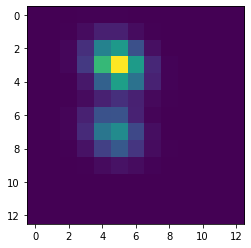

In [54]:
np.random.seed(3)

xm, ym = 4.9, 3.0
xo, yo = 4.7, 7.0
a, b, c = 0.5, -0.1, 0.6

y, x = np.mgrid[:13, :13]
dxm, dym = x - xm, y - ym
dxo, dyo = x - xo, y - yo

bg_mean = 160
bg_sd = 20
bg_int_sd = 5
flux_bkg = np.random.normal(bg_mean, bg_sd, t.shape)

get_psf = lambda dx, dy: np.exp(-(a * dx ** 2 + 2 * b * dx * dy + c * dy ** 2))
psf_main, psf_other = get_psf(dxm, dym), get_psf(dxo, dyo)
true_flux = flux_main + flux_other + flux_bkg
fullframe_main = np.array([f * psf_main for f in flux_main])
fullframe_other = np.array([f * psf_other for f in flux_other])
fullframe_bkg = np.array([np.random.normal(bgi, bg_int_sd, psf_main.shape) for bgi in flux_bkg])
data_arr = fullframe_main + fullframe_other + fullframe_bkg

err_arr = 0.001 * np.ones_like(t)

plt.imshow(data_arr[0])

In [44]:
nstars = 2

model = eleanor.models.Gaussian(
            shape=data_arr.shape[1:], 
            col_ref=0, 
            row_ref=0, 
            xc = [xm, xo],
            yc = [ym, yo],
            nstars = nstars,
            fit_idx = 0,
            bkg0 = flux_bkg[0]
)


loss = lambda mean_val, i: np.sum((mean_val - data_arr[i]) ** 2 / err_arr[i])

def nll(params, i):
    for j, p in enumerate(params):
        if not(model.bounds[j, 0] <= p and p <= model.bounds[j, 1]):
            return np.infty
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = model.mean(fluxes, xshift, yshift, bkg, optpars)
    return loss(mean_val, i)

In [56]:
par = np.concatenate((
            np.max(data_arr[0]) * np.ones(nstars,), 
            np.array([0, 0, flux_bkg[0]]), 
            model.get_default_optpars() 
        ))

nll_arr = np.zeros_like(t)
flux_arr = np.zeros((len(t), nstars))
for i in tqdm.trange(len(data_arr)):
    popt = minimize(nll, par, i, method='TNC', tol=1e-4)
    par = popt.x
    nll_arr[i] = nll(par, i)
    flux_arr[i] = par[:nstars]

100%|██████████| 1200/1200 [04:36<00:00,  4.35it/s]


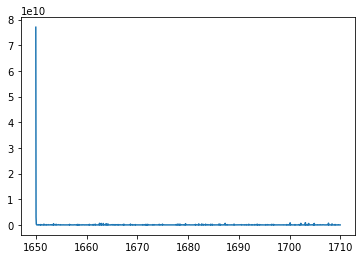

In [57]:
plt.plot(t, nll_arr)

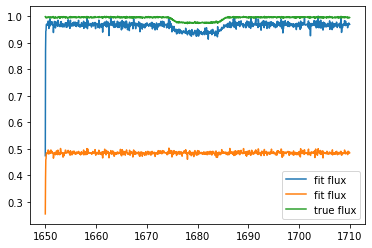

In [60]:
plt.plot(t, flux_arr / np.max(flux_arr), label="fit flux")
plt.plot(t, true_flux / np.max(true_flux), label="true flux")
plt.legend()

In [62]:
popt.x

array([ 5.83739548e+04,  2.91806829e+04,  1.00957429e-03,  4.56001341e-04,
        1.49564267e+02,  4.99334920e-01, -9.98491456e-02,  5.99217796e-01,
        1.00000000e+00])

(0.5, -0.1, 0.6)